In [15]:
import torch
import numpy as np
import zuko
import matplotlib.pyplot as plt
import torch.utils.data as data

In [16]:
# 1. Generate structured noisy data
def get_data_sin_rand(x_start, x_end):
    x = torch.linspace(x_start, x_end, 5000)
    y = 0.01 * x + 0.02 + 0.015 * torch.sin(x * 2) + (0.001 + 0.0015 * x) * torch.empty_like(x).exponential_()
    return torch.stack([x, y], dim=1)

In [17]:
# 2. Get and normalize data
raw_data = get_data_sin_rand(0, 10)
data_mean = raw_data.mean(dim=0)
data_std = raw_data.std(dim=0)
data = (raw_data - data_mean) / data_std

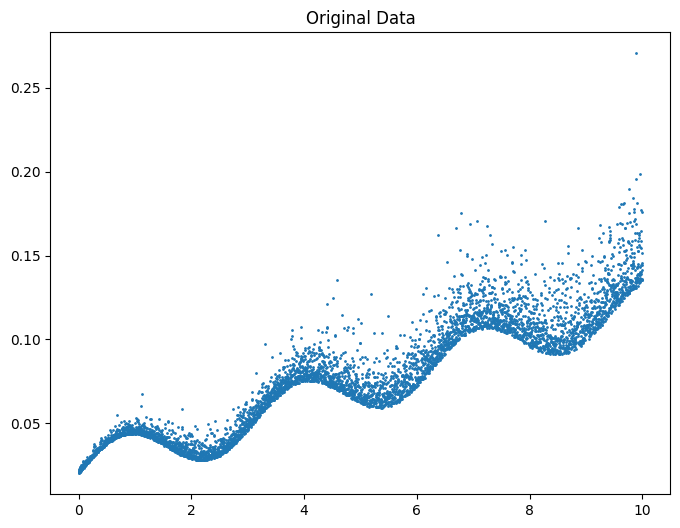

In [18]:
# Plot original data
x = raw_data[:, 0].numpy()
y = raw_data[:, 1].numpy()
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=1)
plt.title("Original Data")
plt.show()

In [19]:
# 3. Data loader
batch_size = 64
trainset = torch.utils.data.TensorDataset(data)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [20]:
# 4. Define conditional flow: p(y | x)
flow = zuko.flows.BPF(features=1, context=1, degree=20, hidden_features=(64, 64))
flow

BPF(
  (transform): LazyComposedTransform(
    (0-2): 3 x ElementWiseTransform(
      (base): BoundedBernsteinTransform()
      (hyper): MLP(
        (0): Linear(in_features=1, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): Linear(in_features=64, out_features=21, bias=True)
      )
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: tensor([0.]), scale: tensor([1.])))
)

In [21]:
# 5. Training
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)
loss_hist = []

for epoch in range(100):
    losses = []

    for (batch,) in trainloader:
        x_ctx = batch[:, 0:1]  # context (x)
        y_val = batch[:, 1:2]  # target (y)

        loss = -flow(x_ctx).log_prob(y_val).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)
    loss_hist.append(losses.mean().item())
    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 1.1272281408309937 ± 0.21237143874168396
(1) 0.699825644493103 ± 0.10682107508182526
(2) 0.48411643505096436 ± 0.08657703548669815
(3) 0.40304112434387207 ± 0.09394009411334991
(4) 0.373445600271225 ± 0.1052371934056282
(5) 0.3459310531616211 ± 0.09083183109760284
(6) 0.32774120569229126 ± 0.09858657419681549
(7) 0.3045479655265808 ± 0.09872115403413773
(8) 0.28355419635772705 ± 0.10594343394041061
(9) 0.26007911562919617 ± 0.09324024617671967
(10) 0.2362755388021469 ± 0.09828951209783554
(11) 0.21283870935440063 ± 0.09842035174369812
(12) 0.18178041279315948 ± 0.09666996449232101
(13) 0.1560937911272049 ± 0.10048894584178925
(14) 0.12142994999885559 ± 0.10544103384017944
(15) 0.08343642950057983 ± 0.11305185407400131
(16) 0.04577052965760231 ± 0.1051962673664093
(17) 0.0184895321726799 ± 0.11924378573894501
(18) -0.019532421603798866 ± 0.1319960355758667
(19) -0.052551377564668655 ± 0.12193385511636734
(20) -0.08089281618595123 ± 0.12152297794818878
(21) -0.11090075969696045 ± 0.1

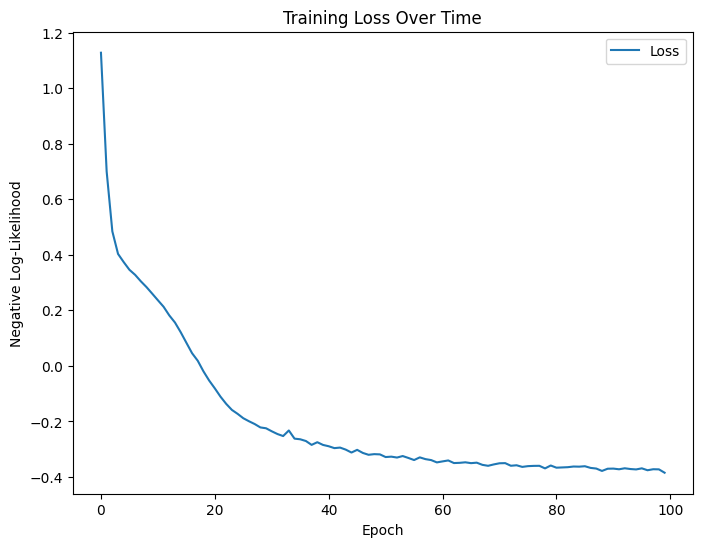

In [22]:
# 6. Plot loss
plt.figure(figsize=(8, 6))
plt.plot(loss_hist, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()

In [23]:
# 7. Sample from the learned distribution p(y | x)
x_values = torch.linspace(0, 10, 500).unsqueeze(1)
x_values_norm = (x_values - data_mean[0]) / data_std[0]  # normalize x
samples_norm = flow(x_values_norm).sample((100,))  # (100, 500, 1)
samples = samples_norm * data_std[1] + data_mean[1]  # denormalize y

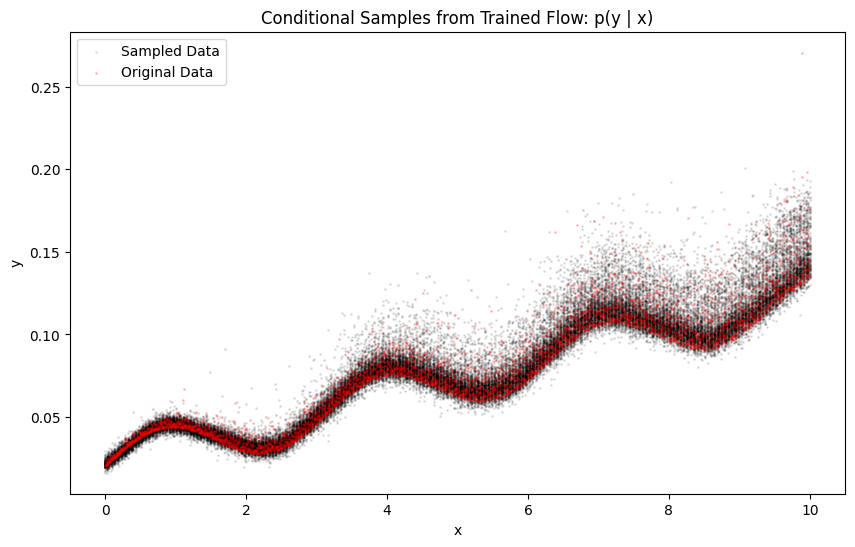

In [24]:
# 8. Plot the sampled y's conditioned on x
plt.figure(figsize=(10, 6))
for i in range(100):  # 100 sampled functions
    plt.scatter(x_values.numpy(), samples[i, :, 0].numpy(), s=1, color='black', alpha=0.1, label="Sampled Data" if i == 0 else "")
plt.scatter(raw_data[:, 0].numpy(), raw_data[:, 1].numpy(), s=1, color='red', alpha=0.2, label="Original Data")
plt.title("Conditional Samples from Trained Flow: p(y | x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


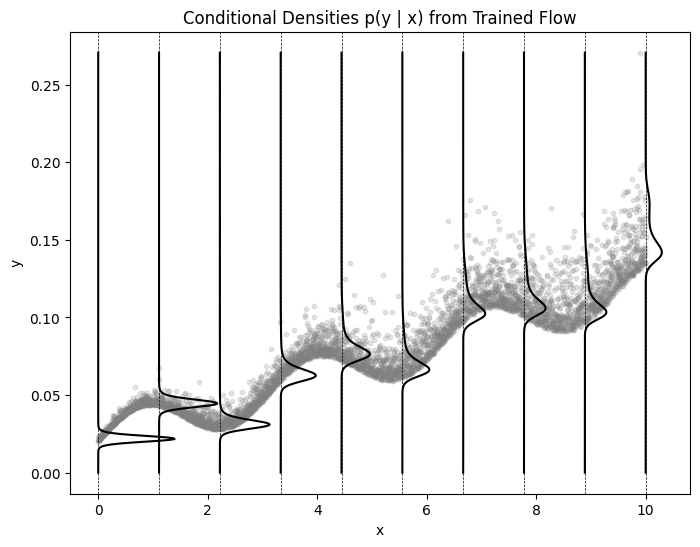

In [25]:
# %%
# 9. Plot conditional densities for fixed x values
import seaborn as sns
from scipy.stats import gaussian_kde

y_max = raw_data[:, 1].numpy().max()

x_slices = torch.linspace(0, 10, 10)  # select 10 x values between 0 and 5
ys = torch.linspace(0, y_max, 500)  # y values for evaluating p(y | x)

plt.figure(figsize=(8, 6))

# Normalize x and y
x_slices_norm = (x_slices - data_mean[0]) / data_std[0]
ys_norm = (ys - data_mean[1]) / data_std[1]

for x_val, x_val_norm in zip(x_slices, x_slices_norm):
    x_context = x_val_norm.unsqueeze(0).unsqueeze(0).expand(ys.shape[0], -1)  # shape (500, 1)
    y_eval = ys_norm.unsqueeze(1)  # shape (500, 1)

    with torch.no_grad():
        log_probs = flow(x_context).log_prob(y_eval)
        probs = torch.exp(log_probs).numpy()

    # Scale and shift to x-position for ridge plot
    probs_scaled = probs * 0.2  # scale for display
    plt.plot(probs_scaled + x_val.item(), ys, color='black')

    # Optional: draw vertical reference line
    plt.axvline(x_val.item(), color='black', linestyle='dashed', linewidth=0.5)

plt.scatter(raw_data[:, 0], raw_data[:, 1], color='gray', alpha=0.2, s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Conditional Densities p(y | x) from Trained Flow")
plt.show()
